In [39]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

import sys

import re
from pprint import pprint
from scipy import interp
from scipy import sparse
from itertools import cycle

import time

from nltk.corpus import stopwords

from nltk.stem.porter import *
from nltk.stem.lancaster import *
from nltk.stem.wordnet import *

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import MultiLabelBinarizer

from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve, auc

In [29]:
random_state = 7

# Load Data

In [4]:
reuters_path = '~/dev/rtc/data/text/reuters21578'

In [5]:
# https://raw.githubusercontent.com/ZhibingChen/DM-Reuters21578/master/reutersCSV.csv
csv_df = pd.read_csv(reuters_path + '/reutersCSV.csv', encoding='iso-8859-1', keep_default_na=False)

In [6]:
csv_df.head()

,pid,fileName,purpose,topic.acq,topic.alum,topic.austdlr,topic.austral,topic.barley,topic.bfr,topic.bop,...,topic.tung,topic.tung.oil,topic.veg.oil,topic.wheat,topic.wool,topic.wpi,topic.yen,topic.zinc,doc.title,doc.text
0,1,0,train,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,BAHIA COCOA REVIEW,Showers continued throughout the week in the B...
1,2,0,train,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,STANDARD OIL &lt;SRD> TO FORM FINANCIAL UNIT,Standard Oil Co and BP North America Inc said ...
2,3,0,train,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,TEXAS COMMERCE BANCSHARES &lt;TCB> FILES PLAN,Texas Commerce Bancshares Inc's Texas Commerce...
3,4,0,train,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,TALKING POINT/BANKAMERICA &lt;BAC> EQUITY OFFER,BankAmerica Corp is not under pressure to act ...
4,5,0,train,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,NATIONAL AVERAGE PRICES FOR FARMER-OWNED RESERVE,The U.S. Agriculture Department reported the f...


#### Peek at texts

In [7]:
# 1 -- 5
(title, text) = csv_df.iloc[1][['doc.title', 'doc.text']]
print(title, '\n\n', text)

STANDARD OIL &lt;SRD> TO FORM FINANCIAL UNIT 

 Standard Oil Co and BP North America Inc said they plan to form a venture to manage the money market borrowing and investment activities of both companies.     BP North America is a subsidiary of British Petroleum Co Plc &lt;BP>, which also owns a 55 pct interest in Standard Oil.     The venture will be called BP/Standard Financial Trading and will be operated by Standard Oil under the oversight of a joint management committee.   Reuter 


#### Topics

In [8]:
all_topics = [ re.sub('topic\.', '', col) for col in csv_df.columns if col.startswith('topic.') ]
print('\n', 'num topics:', len(all_topics))
pd.DataFrame(all_topics, columns=['topic name']).head(15)


 num topics: 135


,topic name
0,acq
1,alum
2,austdlr
3,austral
4,barley
5,bfr
6,bop
7,can
8,carcass
9,castor.meal


### Prepare topics -- the labels we are going to predict

Add them to a dataframe in two ways

#### 1) As lists of zeros and ones -- for humans to read,

In [9]:
topics_binarized = np.array(csv_df.values[:,3:-3])

#### 2) As lists of strings -- for multi-label classifiers.

In [10]:
def topic_list_from_binarized(binarized):
    return [ topic for (has, topic) in zip(binarized, all_topics) if has == 1 ]

topic_lists = [ topic_list_from_binarized(binarized) for binarized in topics_binarized ]

#### Combine all

In [11]:
df = csv_df[[ 'pid', 'purpose', 'doc.title', 'doc.text' ]]
df = df.assign(topic_list = topic_lists)
df = df.assign(topics_binarized = topics_binarized.tolist())
df = df.assign(num_topics = np.array([ len(lst) for lst in topic_lists ]))
df.head()

,pid,purpose,doc.title,doc.text,topic_list,topics_binarized,num_topics
0,1,train,BAHIA COCOA REVIEW,Showers continued throughout the week in the B...,[cocoa],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",1
1,2,train,STANDARD OIL &lt;SRD> TO FORM FINANCIAL UNIT,Standard Oil Co and BP North America Inc said ...,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
2,3,train,TEXAS COMMERCE BANCSHARES &lt;TCB> FILES PLAN,Texas Commerce Bancshares Inc's Texas Commerce...,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
3,4,train,TALKING POINT/BANKAMERICA &lt;BAC> EQUITY OFFER,BankAmerica Corp is not under pressure to act ...,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
4,5,train,NATIONAL AVERAGE PRICES FOR FARMER-OWNED RESERVE,The U.S. Agriculture Department reported the f...,"[barley, corn, grain, oat, sorghum, wheat]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6


### Keep only a few good topics and only single-topic docs

In [12]:
roughly_even_topics = [
    'money.fx',
    'crude',
    'grain',
    'trade',
    'interest',
]
all_topics = roughly_even_topics

#### Later we will need a special binary representation of labels
For compatibility with library functions that calculate metrics

In [13]:
roughly_even_topics_set = set(roughly_even_topics)
df = df[df.apply(
    lambda row: len(row['topic_list']) == 1 and set(row['topic_list']).issubset(roughly_even_topics_set),
    axis = 1
)]

In [14]:
binarizer = MultiLabelBinarizer(classes = roughly_even_topics)

In [15]:
topic_lists = df.apply(lambda row : row['topic_list'][0], axis = 1).values.reshape(len(df), 1)
roughly_even_topics_binarized = binarizer.fit_transform(topic_lists)
roughly_even_topics_binarized[:5]

array([[0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0]])

In [16]:
df = df.assign(topics_binarized = roughly_even_topics_binarized.tolist())

### So the data we will use is...

In [17]:
df_train = df[df['purpose'] == 'train']
df_test = df[df['purpose'] == 'test']

In [18]:
n_classes = len(all_topics)

In [19]:
print('total docs', len(df))
print('num train examples', len(df_train))
print('num test examples', len(df_test))
df.head()

total docs 1414
num train examples 943
num test examples 377


,pid,purpose,doc.title,doc.text,topic_list,topics_binarized,num_topics
46,47,train,BRAZIL ANTI-INFLATION PLAN LIMPS TO ANNIVERSARY,"inflation plan, initially hailed at home and a...",[trade],"[0, 0, 0, 1, 0]",1
123,124,train,U.S. GRAIN CARLOADINGS FALL IN WEEK,"U.S. grain carloadings totaled 26,108 cars in ...",[grain],"[0, 0, 1, 0, 0]",1
126,127,train,DIAMOND SHAMROCK (DIA) CUTS CRUDE PRICES,Diamond Shamrock Corp said that effective toda...,[crude],"[0, 1, 0, 0, 0]",1
135,136,train,GAO LIKELY TO SHOW CERTS MORE COSTLY THAN CASH,A study on grain certificates due out shortly ...,[grain],"[0, 0, 1, 0, 0]",1
143,144,train,OPEC MAY HAVE TO MEET TO FIRM PRICES - ANALYSTS,OPEC may be forced to meet before a scheduled ...,[crude],"[0, 1, 0, 0, 0]",1


### Some stats

#### Num topics per document

total docs: 1414
docs with at least one topic: 1414
docs with more than one topic: 0
docs with more than two topics: 0
docs with exactly one topic: 1414


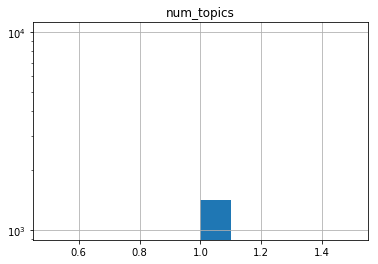

In [20]:
fig, ax = plt.subplots()
ax.set_yscale('log')

df[['num_topics']].hist(ax = ax)

print('total docs:', len(df))
print('docs with at least one topic:', len(df[df['num_topics'] > 0]))
print('docs with more than one topic:', len(df[df['num_topics'] > 1]))
print('docs with more than two topics:', len(df[df['num_topics'] > 2]))
print('docs with exactly one topic:', len(df[df['num_topics'] == 1]))

#### Num documents per topic

##### Calculate

In [21]:
really_want_to_recalc_num_docs_by_topic = True
if really_want_to_recalc_num_docs_by_topic:
    num_docs_by_topic = df.from_records(
        data = [ 
            (topic, len(df[df.apply(lambda row: topic in row['topic_list'], axis=1)]))
            for topic in all_topics
        ],
        columns = [ 'topic', 'num_docs' ]
    ).sort_values('num_docs', ascending = False)
    # beware not to overwrite data that is costly to compute again
    # num_docs_by_topic.to_csv(reuters_path + '/num_docs_by_topic.csv', index = False)
else:
    num_docs_by_topic = pd.read_csv(reuters_path + '/num_docs_by_topic.csv')
    num_docs_by_topic = num_docs_by_topic.sort_values('num_docs', ascending = False)

##### Show

[Text(0,0.5,'num_docs')]

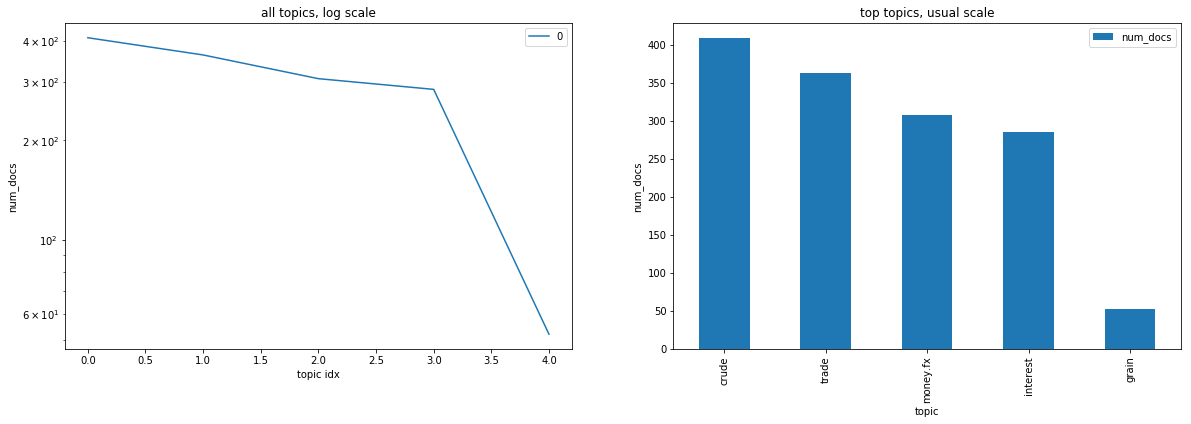

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
axs[0].set_yscale('log')
axs[0].set_title('all topics, log scale')
axs[1].set_title('top topics, usual scale')
pd.DataFrame(num_docs_by_topic[['num_docs']].values).plot(ax = axs[0]).set(xlabel = 'topic idx', ylabel = 'num_docs')
num_docs_by_topic.head(10).plot(ax = axs[1], kind = 'bar', x = 'topic').set(ylabel = 'num_docs')

#### Num words per document

In [23]:
num_words = df[['doc.title', 'doc.text']].apply(
    lambda row: len((row['doc.title'] + ' ' + row['doc.text']).split()),
    axis = 1
)

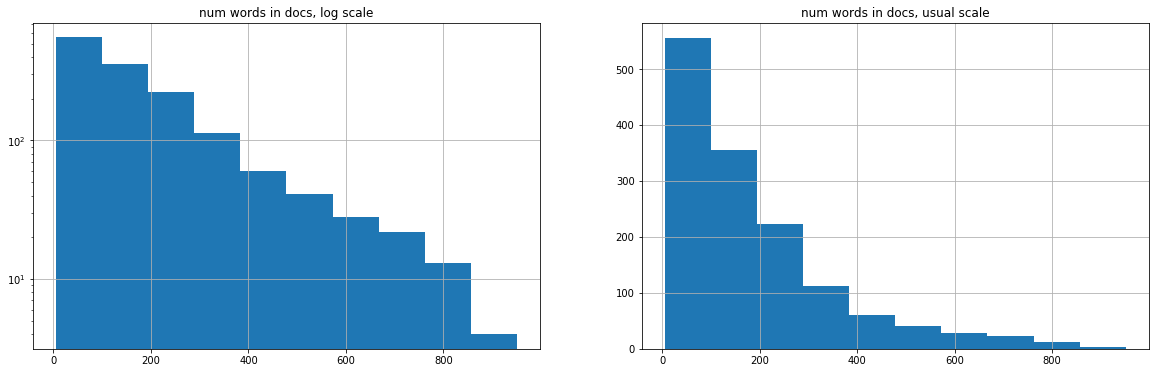

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
axs[0].set_yscale('log')
axs[0].set_title('num words in docs, log scale')
axs[1].set_title('num words in docs, usual scale')

num_words.hist(ax = axs[0])
num_words.hist(ax = axs[1])

#### Total num distinct words and word counts

In [25]:
def get_counts_by_word(docs):
    word_counts = {}
    for doc in docs:
        for word in doc.split():
            if len(word) > 0:
                if word not in word_counts:
                    word_counts[word] = 0
                word_counts[word] += 1
    return word_counts

In [26]:
counts_by_word = get_counts_by_word(
    df.apply(lambda row : row['doc.title'] + ' ' + row['doc.text'], axis = 1).values
)

In [27]:
len(counts_by_word.keys())

23568

## Create features

The whole task actually revolves around how we represent the documents as vectors that can be fed to a classifier.

Here we will use the Bag Of Words approach:

1. split each text to tokens and create a set of all words of all texts -- the vocabulary,
2. create a matrix in which rows correspond to docs and columns -- to words,
3. fill the matrix with either of:
  * 1 if the word is found in the doc and else 0,
  * word count in doc,
  * TF-IDF numbers.
  
Questions:

1. How to split the text to tokens ? By whitespace ? Punctuation ? Some other way ?
2. What if the words have different forms ?
3. What if there are lots of different numbers ?
4. What if there are common sequences of words, like "United Kingdom", "Russian Federation", "United States of America"
5. What if there are lots of words like "a", "the", "they" etc. that appear in many documets ?

### What do texts actually look like

In [28]:
# in full dataset:
# 1,2 -- have &lt; == '<' symbol (less than, a way to escape it in HTML)
# 3   -- a lot of text
# 4   -- a table of numbers
# 5   -- a lot of numbers
#
# in truncated dataset:
# 1   -- just regular text
# 4   -- longer text
# 5   -- only title
# 6   -- has &lt; (see above) and some numbers
# 100 -- has a table of some sort
#
# some words are upper case, some lower, some even mixed (doc 5)
# a lot of punctuation
# numbers are in different formats
# Reuter word at the end of each document
# some words are abbreviated

(title, text) = df.iloc[1][['doc.title', 'doc.text']]
print(title, '\n\n', text)

U.S. GRAIN CARLOADINGS FALL IN WEEK 

 U.S. grain carloadings totaled 26,108 cars in the week ended February 21, down 2.2 pct from the previous week but 22.8 pct above the corresponding week a year ago, the Association of American Railroads reported.     Grain mill product loadings in the week totalled 11,382 cars, down 1.8 pct from the previous week but 7.6 pct above the same week a year earlier, the association said.  Reuter 


### Pre-process text

In [29]:
def lower_case(string):
    return string.lower()

def fix_lt(string):
    # fix the HTML-escaped less-than sign
    return re.sub(r'&lt;', '<', string)

def remove_reuter(string):
    # fix the HTML-escaped less-than sign
    return re.sub(r'reuter$', '', string)

def replace_non_alphanumeric_with_space(string):
    # replace punctuation and different whitespace with space character
    return re.sub(r'[^a-z0-9 ]', ' ', string)

def strip_punctuation(string):
    # remove punctuation
    return re.sub(r'[^a-z0-9\s]', ' ', string)

def remove_stop_words(string, stop_words):
    return ' '.join([ word for word in re.split(' ', string) if not word in stop_words ])

def replace_numeric_with_literal(string):
    return re.sub(r'([0-9]+ ?)+', '<num> ', string)

def compact_whitespace(string):
    return re.sub(r'\s+', ' ', string)

def stem(string, stemmer):
    return ' '.join([ stemmer.stem(word) for word in re.split(' ', string) if not word in stop_words ])

In [30]:
stop_words = stopwords.words('english')

stemmer = LancasterStemmer()
# stemmer = PorterStemmer()
# stemmer = WordNetLemmatizer()

In [31]:
def pre_process(string):
    s = lower_case(string)
    s = fix_lt(s)
    s = remove_reuter(s)
    s = strip_punctuation(s)
    s = remove_stop_words(s, stop_words)
    s = compact_whitespace(s)
    s = replace_numeric_with_literal(s)
    s = stem(s, stemmer)
    return s.strip()

In [32]:
example = 'Autobahn-FX 2, &lt;RMS> are now being actively developed; GDS decom will be finished by 2055 or 2056'
pre_process(example)

'autobahn fx <num> rms act develop gds decom fin <num>'

In [33]:
(title, text) = df.iloc[1][['doc.title', 'doc.text']]
print(title, '\n\n', text, '\n\n', pre_process(title + ' ' + text))

U.S. GRAIN CARLOADINGS FALL IN WEEK 

 U.S. grain carloadings totaled 26,108 cars in the week ended February 21, down 2.2 pct from the previous week but 22.8 pct above the corresponding week a year ago, the Association of American Railroads reported.     Grain mill product loadings in the week totalled 11,382 cars, down 1.8 pct from the previous week but 7.6 pct above the same week a year earlier, the association said.  Reuter  

 u grain carload fal week u grain carload tot <num> car week end febru <num> pct prevy week <num> pct correspond week year ago assocy am railroad report grain mil produc load week total <num> car <num> pct prevy week <num> pct week year ear assocy said reut


#### Get pre-processed text sets

In [34]:
def pre_process_df(df):
    return df.apply(lambda row : pre_process(row['doc.title'] + ' ' + row['doc.text']), axis = 1).values

In [35]:
pre_processed_train = pre_process_df(df_train)

In [36]:
pre_processed_test = pre_process_df(df_test)

#### Check vocabulary

In [37]:
counts_by_word_pre_processed_train = get_counts_by_word(pre_processed_train)

In [38]:
len(counts_by_word_pre_processed_train)

5199

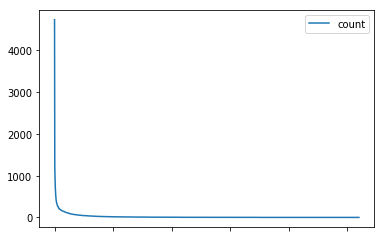

In [39]:
pd.DataFrame(pd.Series(counts_by_word_pre_processed_train, name='count')).sort_values('count', ascending=False).plot()

In [40]:
num_words = 3000

In [41]:
pd.DataFrame(pd.Series(counts_by_word_pre_processed_train, name='count')).sort_values('count', ascending=False)[4:num_words].head(20)

,count
bank,1250
oil,1108
bil,1062
pct,1029
rat,964
reut,897
mln,857
market,833
would,814
year,756


In [42]:
pd.DataFrame(pd.Series(counts_by_word_pre_processed_train, name='count')).sort_values('count', ascending=False)[:num_words].tail()

,count
w<num>,2
autonom,2
altogeth,2
sak,2
caf,2


In [43]:
top_words = list(counts_by_word_pre_processed_train.items())
top_words.sort(key = lambda it: it[1])
top_words.reverse()
top_words = [ word for word, count in top_words[:num_words] ]
print(len(top_words))
top_words[:10]

3000


['<num>', 'said', 'trad', 'u', 'bank', 'oil', 'bil', 'pct', 'rat', 'reut']

In [44]:
def replace_rare_words_with_literal(string, top_words):
    return ' '.join([ (word if word in top_words else '<unk>') for word in re.split(' ', string) ])

In [45]:
pre_processed_train = [ 
    replace_rare_words_with_literal(doc, top_words) for doc in pre_processed_train
]

pre_processed_test = [ 
    replace_rare_words_with_literal(doc, top_words) for doc in pre_processed_test
]

In [46]:
print(pre_processed_train[:3])
print()
print(pre_processed_test[:3])

['brazil ant infl plan limp annivers infl plan init <unk> hom abroad <unk> econom limp toward first annivers amid soar pric widespread short foreign pay cris annount last febru <num> plan froz pric fix valu new <unk> cur end widespread index econom bid halt country <num> pct infl rat within year plan collaps situ wors although infl least econom work lead bank econom said <unk> plan accompany dram revers foreign trad account <num> brazil an trad surplus sufficy cov <num> bil dlrs nee serv <num> bil dlr foreign debt first nin month <num> seem target rep month surplus av on bil dlrs export divert import increas avoid domest short trad surpl plung <num> mln dlrs octob sint av <num> mln reut', 'u grain carload fal week u grain carload tot <num> car week end febru <num> pct prevy week <num> pct correspond week year ago assocy am railroad report grain mil produc load week total <num> car <num> pct prevy week <num> pct week year ear assocy said reut', 'diamond shamrock dia cut crud pric diamon

### Vectorize text

In [47]:
vectorizer = TfidfVectorizer(ngram_range = (1, 1))

vectorizer.fit(pre_processed_train)

X_train = vectorizer.transform(pre_processed_train, copy=True)
X_test = vectorizer.transform(pre_processed_test, copy=True)

In [48]:
X_train.shape

(943, 2986)

### Prepare labels

In [49]:
def single_label(df):
    return df.apply(lambda row : row['topic_list'][0], axis = 1).values

In [50]:
def binarized(df):
    return sparse.csr_matrix(df.apply(lambda row : row['topics_binarized'], axis = 1).values.tolist())

In [51]:
y_train = single_label(df_train)
y_test = single_label(df_test)

## Train the model

In [52]:
# y_train_labels = binarizer.inverse_transform(y_train)

In [53]:
# clf = MLPClassifier()
# clf = MultinomialNB()
clf = LogisticRegression(multi_class='multinomial', solver='lbfgs') # accepts array of single labels

clf = clf.fit(X_train, y_train)

## Check quality

In [54]:
y_test_predicted_labels = clf.predict(X_test)
# y_test_predicted_scores = clf.decision_function(X_test)

In [55]:
y_test_predicted_labels_binary = binarizer.transform(y_test_predicted_labels.reshape(len(y_test_predicted_labels), 1))
y_test_binary = binarizer.transform(y_test.reshape(len(y_test), 1))

In [56]:
def print_evaluation_scores(y_test, predicted):
    print('accuracy', accuracy_score(y_test, predicted))
    for avg in [ 'micro', 'macro', 'weighted' ]:
        print('f1', avg, f1_score(y_test, predicted, average = avg))
        print('precision', avg, average_precision_score(y_test, predicted, average = avg))

In [57]:
print_evaluation_scores(y_test_binary, y_test_predicted_labels_binary)

accuracy 0.9363395225464191
f1 micro 0.9363395225464191
precision micro 0.8894637969731722
f1 macro 0.9249925350513717
precision macro 0.8728618721996421
f1 weighted 0.9354465797174518
precision weighted 0.8918616599896273


## Fiddle around with the classifier

In [58]:
df_test[4:9]

,pid,purpose,doc.title,doc.text,topic_list,topics_binarized,num_topics
14911,14912,test,JAPAN GIVEN LITTLE HOPE OF AVOIDING U.S. SANCT...,A top U.S. Official said Japan has little chan...,[trade],"[0, 0, 0, 1, 0]",1
14986,14987,test,STOLTENBERG SEES MOVES TO STRENGTHEN PARIS ACCORD,West German Finance Minister Gerhard Stoltenbe...,[money.fx],"[1, 0, 0, 0, 0]",1
15047,15048,test,TOP OFFICIALS ARRIVE AT TREASURY FOR G-5 TALKS,Top officials of leading industrial nations ar...,[money.fx],"[1, 0, 0, 0, 0]",1
15048,15049,test,FED EXPECTED TO SET CUSTOMER REPURCHASES,The Federal Reserve is expected to intervene i...,[interest],"[0, 0, 0, 0, 1]",1
15091,15092,test,"FED SETS OVERNIGHT SYSTEM REPURCHASES, FED SAYS",,[interest],"[0, 0, 0, 0, 1]",1


In [59]:
print(df_test.iloc[5]['doc.title'] + '\n\n' + df_test.iloc[5]['doc.text'])

STOLTENBERG SEES MOVES TO STRENGTHEN PARIS ACCORD

West German Finance Minister Gerhard Stoltenberg said today's meetings of major industrial countries would look at ways of strengthening the Paris accord on stabilizing foreign exchange rates.     Stoltenberg told journalists he saw no fundamental weakness of the February 22 agreement of the Group of Five countries and Canada to keep exchange rates near the then-current levels.     But he declined to say what measures would be discussed ahead of a communique of the Group of Seven ministers later today.     Stoltenberg and Bundesbank President Karl Otto Poehl said the importance of the Paris agreement, also known as the Louvre accord, had been underestimated.     Stoltenberg said there is greater agreement now among major countries than six months ago, at the time of the annual meeting of the International Monetary Fund and World Bank, marked by sharp discord between the United States and its major trading partners.     "There is no fun

## Interpreting features

In [60]:
num_top_features = 10
pd.set_option('max_colwidth', 200)
pd.DataFrame.from_records(
    columns = [ 'topic', 'top_words' ],
    data = [ (
        cls, 
        [ vectorizer.get_feature_names()[i] for i in np.argpartition(coefs, -num_top_features)[-num_top_features:] ]
    ) for cls, coefs in zip(clf.classes_, clf.coef_) ]
)

,topic,top_words
0,crude,"[expl, bpd, petrole, energy, refinery, oil, crud, pric, barrel, opec]"
1,grain,"[elev, cer, usd, ton, soviet, farm, cert, agricult, crop, grain]"
2,interest,"[discount, point, num, cut, interest, fed, prim, rat, bank, pct]"
3,money.fx,"[par, stabl, market, cur, bank, doll, exchang, stg, monet, money]"
4,trade,"[janu, import, gat, surpl, japanes, bil, deficit, jap, trad, export]"


## Try to plot ROC

In [ ]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binary[:,i], y_test_predicted_scores[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binary.ravel(), y_test_predicted_scores.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [ ]:
# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

In [ ]:
lw = 2

# Plot all ROC curves
plt.figure(figsize=(20, 10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

# Full Flow

In [50]:
# PARAMETERS -------------------------------------------------------
CASE_NAME = 'CASE_NAME'
TOPICS = 'TOPICS'
MODEL = 'MODEL'
VECTORIZER = 'VECTORIZER'
PP_LOWER_CASE = 'PP_LOWER_CASE'
PP_FIX_LT = 'PP_FIX_LT'
PP_REMOVE_REUTER = 'PP_REMOVE_REUTER'
PP_STRIP_PUNCTUATION = 'PP_STRIP_PUNCTUATION'
PP_REMOVE_STOP_WORDS = 'PP_REMOVE_STOP_WORDS'
PP_COMPACT_WHITESPACE = 'PP_COMPACT_WHITESPACE'
PP_NUMERIC = 'PP_NUMERIC'
PP_REPLACE_NUMERIC_WITH_LITERAL = 'PP_REPLACE_NUMERIC_WITH_LITERAL'
PP_NUMERIC_AS_IS = 'PP_NUMERIC_AS_IS'
PP_NUMERIC_DROP = 'PP_NUMERIC_DROP'
PP_STEM = 'PP_STEM'
PP_STEM_PORTER = 'PP_STEM_PORTER'
PP_STEM_LANCASTER = 'PP_STEM_LANCASTER'
PP_LEMMATIZE = 'PP_LEMMATIZE'
NUM_TOP_WORDS_TO_TAKE = 'NUM_TOP_WORDS_TO_TAKE'
RARE_WORDS = 'RARE_WORDS'
RARE_WORDS_REPLACE = 'RARE_WORDS_REPLACE'
RARE_WORDS_DROP = 'RARE_WORDS_DROP'
RARE_WORDS_AS_IS = 'RARE_WORDS_AS_IS'

def default_parameters():
    return {
        CASE_NAME : 'logreg multinomial',
        MODEL : LogisticRegression(multi_class='multinomial', solver='lbfgs'), # accepts array of single labels
        VECTORIZER : TfidfVectorizer(ngram_range = (1, 1)),
        TOPICS : [ 'money.fx', 'crude', 'grain', 'trade', 'interest', ], # classes for single-label multi-class model
        PP_LOWER_CASE : True,
        PP_FIX_LT : True,
        PP_REMOVE_REUTER : True,
        PP_STRIP_PUNCTUATION : True,
        PP_REMOVE_STOP_WORDS : True,
        PP_COMPACT_WHITESPACE : True,
        PP_NUMERIC: PP_REPLACE_NUMERIC_WITH_LITERAL, # PP_NUMERIC_DROP # PP_NUMERIC_AS_IS
        PP_STEM : PP_STEM_LANCASTER, # PP_STEM_PORTER # PP_STEM_LANCASTER # PP_LEMMATIZE
        RARE_WORDS : RARE_WORDS_REPLACE, # RARE_WORDS_DROP
        NUM_TOP_WORDS_TO_TAKE : 3000, # top words by count to build vocabulary of
    }

# LABEL BINARIZATION -----------------------------------------------

def topic_list_from_binarized(binarized, topics):
    return [ topic for (has, topic) in zip(binarized, topics) if has == 1 ]

def single_label(df):
    return df.apply(lambda row : row['topic_list'][0], axis = 1).values

def binarized(df):
    return sparse.csr_matrix(df.apply(lambda row : row['topics_binarized'], axis = 1).values.tolist())

# PREPROCESSING ----------------------------------------------------

def lower_case(string):
    return string.lower()

def fix_lt(string):
    # fix the HTML-escaped less-than sign
    return re.sub(r'&lt;', '<', string)

def remove_reuter(string):
    # fix the HTML-escaped less-than sign
    return re.sub(r'reuter$', '', string)

def replace_non_alphanumeric_with_space(string):
    # replace punctuation and different whitespace with space character
    return re.sub(r'[^a-z0-9 ]', ' ', string)

def strip_punctuation(string):
    # remove punctuation
    return re.sub(r'[^a-z0-9\s]', ' ', string)

def remove_stop_words(string, stop_words):
    return ' '.join([ word for word in re.split(' ', string) if not word in stop_words ])

def replace_numeric_with_literal(string, literal = '<num> '):
    return re.sub(r'([0-9]+ ?)+', literal, string)

def compact_whitespace(string):
    return re.sub(r'\s+', ' ', string)

def stem(string, stemmer):
    return ' '.join([ stemmer.stem(word) for word in re.split(' ', string) if not word in stop_words ])

stop_words = stopwords.words('english')

def pre_process(params, string):
    s = string
    if params[PP_LOWER_CASE]:
        s = lower_case(string)
    if params[PP_FIX_LT]:
        s = fix_lt(s)
    if params[PP_REMOVE_REUTER]:
        s = remove_reuter(s)
    if params[PP_STRIP_PUNCTUATION]:
        s = strip_punctuation(s)
    if params[PP_REMOVE_STOP_WORDS]:
        s = remove_stop_words(s, stop_words)
    if params[PP_COMPACT_WHITESPACE]:
        s = compact_whitespace(s)
    if params[PP_NUMERIC] == PP_REPLACE_NUMERIC_WITH_LITERAL:
        s = replace_numeric_with_literal(s)
    elif params[PP_NUMERIC] == PP_NUMERIC_DROP:
        s = replace_numeric_with_literal(s, '')
    if params[PP_STEM] == PP_STEM_LANCASTER:
        stemmer = LancasterStemmer()
        s = stem(s, stemmer)
    elif params[PP_STEM] == PP_STEM_PORTER:
        stemmer = PorterStemmer()
        s = stem(s, stemmer)
    elif params[PP_STEM] == PP_LEMMATIZE:
        stemmer = WordNetLemmatizer()
        s = stem(s, stemmer)
    return s.strip()

def pre_process_df(params, df):
    return df.apply(lambda row : pre_process(params, row['doc.title'] + ' ' + row['doc.text']), axis = 1).values

def get_counts_by_word(docs):
    word_counts = {}
    for doc in docs:
        for word in doc.split():
            if len(word) > 0:
                if word not in word_counts:
                    word_counts[word] = 0
                word_counts[word] += 1
    return word_counts

def replace_rare_words_with_literal(string, top_words, literal = '<unk>'):
    return ' '.join([ (word if word in top_words else literal) for word in re.split(' ', string) ])

# METRICS --------------------------------------------------------

def print_evaluation_scores(y_test, predicted):
    print('accuracy', accuracy_score(y_test, predicted))
    for avg in [ 'micro', 'macro', 'weighted' ]:
        print('f1', avg, f1_score(y_test, predicted, average = avg))
        print('precision', avg, average_precision_score(y_test, predicted, average = avg))
        # 'micro': Calculate metrics globally by counting the total true positives, false negatives and false positives.
        # 'macro': Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
        # 'weighted': Calculate metrics for each label, and find their average, weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall.
        
# ACTUAL FLOW ----------------------------------------------------

def run(params):
    print('------------------------------------------------------')
    print(time.time())
    pprint(params[CASE_NAME])

    topics = params[TOPICS]
    n_classes = len(topics)
    topics_set = set(topics)

    # LOAD DATA --------------------------------------------------------
    started_loading = time.time()
    
    reuters_path = '~/dev/rtc/data/text/reuters21578'
    # https://raw.githubusercontent.com/ZhibingChen/DM-Reuters21578/master/reutersCSV.csv
    csv_df = pd.read_csv(reuters_path + '/reutersCSV.csv', encoding='iso-8859-1', keep_default_na=False)

    # ORGANIZE DATA ----------------------------------------------------

    # take only what's needed (columns 'topic_list' and 'num_topics' added separately below)
    df = csv_df[[ 'pid', 'purpose', 'doc.title', 'doc.text' ]]

    # get specified topics
    all_topics = [ re.sub('topic\.', '', col) for col in csv_df.columns if col.startswith('topic.') ]

    # store topics for all docs before filtering them according to the specified topics list
    all_topics_binary = np.array(csv_df.values[:,3:-3])
    topic_lists_long = [ topic_list_from_binarized(binary, all_topics) for binary in all_topics_binary ]
    df = df.assign(topic_list = topic_lists_long)
    df = df.assign(num_topics = np.array([ len(lst) for lst in topic_lists_long ]))

    # keep only docs that have exactly one topic and that is within the specified topics list
    df = df[df.apply(
        lambda row: row['num_topics'] == 1 and set(row['topic_list']).issubset(topics_set),
        axis = 1
    )]

    # Binarizing labels for API compatibility
    # could have taken from CSV with some dataframe wrangling -- in this case
    # in general -- a Binarizer may well be needed anyway, so showing it
    
    binarizer = MultiLabelBinarizer(classes = topics)
    topic_lists = df.apply(lambda row : row['topic_list'][0], axis = 1).values.reshape(len(df), 1)
    topics_binarized = binarizer.fit_transform(topic_lists)
    df = df.assign(topics_binarized = topics_binarized.tolist())
    
    # train-test split -- as per the dataset markup
    df_train = df[df['purpose'] == 'train']
    df_test = df[df['purpose'] == 'test']
        
    # PRE-PROCESS TEXT --------------------------------------------------
    started_pre_processing = time.time()

    # case, punctuation, stop-words, whitespace etc.
    pre_processed_train = pre_process_df(params, df_train)
    pre_processed_test = pre_process_df(params, df_test)
    
    # deal with rare words
    if params[NUM_TOP_WORDS_TO_TAKE] > 0:
        num_words = params[NUM_TOP_WORDS_TO_TAKE]
        counts_by_word = get_counts_by_word(pre_processed_train)
        top_words = list(counts_by_word.items())
        top_words.sort(key = lambda it: it[1])
        top_words.reverse()
        top_words = [ word for word, count in top_words[:num_words] ]
        if params[RARE_WORDS] == RARE_WORDS_REPLACE:
            pre_processed_train = [ replace_rare_words_with_literal(doc, top_words) for doc in pre_processed_train ]
            pre_processed_test = [ replace_rare_words_with_literal(doc, top_words) for doc in pre_processed_test ]
        elif params[RARE_WORDS] == RARE_WORDS_DROP:
            pre_processed_train = [ replace_rare_words_with_literal(doc, top_words, '') for doc in pre_processed_train ]
            pre_processed_test = [ replace_rare_words_with_literal(doc, top_words, '') for doc in pre_processed_test ]

    # CREATE FEATURE REPRESENTATION AND LABELS ---------------------------
    started_vectorizing = time.time()

    vectorizer = params[VECTORIZER]

    vectorizer.fit(pre_processed_train)

    X_train = vectorizer.transform(pre_processed_train)
    X_test = vectorizer.transform(pre_processed_test)

    y_train = single_label(df_train)
    y_test = single_label(df_test)
    # y_train_labels = binarizer.inverse_transform(y_train)

    # TRAIN THE MODEL ----------------------------------------------------
    started_training = time.time()

    clf = params[MODEL]

    clf = clf.fit(X_train, y_train)

    # CHECK METRICS ------------------------------------------------------
    started_checking_metrics = time.time()

    y_test_predicted_labels = clf.predict(X_test)

    try:
        # binarize for metrics calculation
        y_test_predicted_labels_binary = binarizer.transform(y_test_predicted_labels.reshape(len(y_test_predicted_labels), 1))
        y_test_binary = binarizer.transform(y_test.reshape(len(y_test), 1))

        # print most important features
        if (hasattr(clf, 'coef_')):
            num_top_features = 10
            top_features = pd.DataFrame.from_records(
                columns = [ 'topic', 'top_words' ],
                data = [ (
                    cls, 
                    [ vectorizer.get_feature_names()[i] for i in np.argpartition(coefs, -num_top_features)[-num_top_features:] ]
                ) for cls, coefs in zip(clf.classes_, clf.coef_) ]
            )
            top_features.head()

        # print metrics
        started_rendering_metrics = time.time()
        print_evaluation_scores(y_test_binary, y_test_predicted_labels_binary)

        done = time.time()
        print('timing:')
        print(
            'done in', done - started_loading, '(',
            'loading:', started_pre_processing - started_loading,
            ', pre-processing:', started_vectorizing - started_pre_processing,
            ', vectorizing:', started_training - started_vectorizing,
            ', training:', started_checking_metrics - started_training,
            ', checking metrics', started_rendering_metrics - started_checking_metrics,
            ', rendering metrics', done - started_rendering_metrics,
            ')'    
        )
    except:
        print("Could not calculate metrics:", sys.exc_info())


In [48]:
params = default_parameters()

run(params)

------------------------------------------------------
1535005605.4483755
'logreg multinomial'
accuracy 0.9363395225464191
f1 micro 0.9363395225464191
precision micro 0.8894637969731722
f1 macro 0.9249925350513717
precision macro 0.8728618721996421
f1 weighted 0.9354465797174518
precision weighted 0.8918616599896273
timing:
done in 55.044326305389404 ( loading: 36.38390564918518 , pre-processing: 17.07181191444397 , vectorizing: 0.68984055519104 , training: 0.6921205520629883 , checking metrics 0.179732084274292 , rendering metrics 0.026915550231933594 )


In [ ]:
for pp_remove_reuter in [ True, False ]:
    for pp_fix_lt in [ True, False ]:
        for pp_lower_case in [ True, False ]:
            for pp_strip_punctuation in [ True, False ]:
                for pp_remove_stop_words in [ True, False ]:
                    for pp_compact_whitespace in [ True ]: # , False ]:
                        for pp_numeric in [ PP_REPLACE_NUMERIC_WITH_LITERAL, PP_NUMERIC_DROP, PP_NUMERIC_AS_IS ]:
                            for pp_stem in [ PP_STEM_LANCASTER, PP_STEM_PORTER ]: #, PP_LEMMATIZE ]:
                                for num_top_words_to_take in [ -1, 3000, 6000, 12000 ]:
                                    for rare_words in ([ RARE_WORDS_REPLACE, RARE_WORDS_DROP ] if num_top_words_to_take > 0 else [ RARE_WORDS_AS_IS ]):
                                        for vectorizer in [
                                            CountVectorizer(),
                                            TfidfVectorizer(ngram_range = (1, 1)),
                                            TfidfVectorizer(ngram_range = (1, 2)),
                                            TfidfVectorizer(ngram_range = (1, 3)),
                                        ]:
                                            for case_name, model in [
                                                ("MLPClassifier(alpha=1, max_iter=500)", MLPClassifier(alpha=1, max_iter=500)),
                                                ("LogisticRegression(multi_class='multinomial', solver='lbfgs')", LogisticRegression(multi_class='multinomial', solver='lbfgs')),
                                                ("MultinomialNB()", MultinomialNB()),
                                                ("KNeighborsClassifier(15)", KNeighborsClassifier(15)),
                                                ("SVC(kernel='linear', C=0.025)", SVC(kernel='linear', C=0.025)),
                                                ("SVC(gamma=2, C=1)", SVC(gamma=2, C=1)),
                                                ("DecisionTreeClassifier(max_depth=50)", DecisionTreeClassifier(max_depth=50)),
                                                ("RandomForestClassifier(max_depth=50, n_estimators=1000, max_features=1)", RandomForestClassifier(max_depth=50, n_estimators=1000, max_features=1)),
                                            ]:
                                                params = {
                                                    MODEL : model,
                                                    VECTORIZER : vectorizer,
                                                    TOPICS : [ 'money.fx', 'crude', 'grain', 'trade', 'interest', ],
                                                    PP_LOWER_CASE : pp_lower_case,
                                                    PP_FIX_LT : pp_fix_lt,
                                                    PP_REMOVE_REUTER : pp_remove_reuter,
                                                    PP_STRIP_PUNCTUATION : pp_strip_punctuation,
                                                    PP_REMOVE_STOP_WORDS : pp_remove_stop_words,
                                                    PP_COMPACT_WHITESPACE : pp_compact_whitespace,
                                                    PP_NUMERIC: pp_numeric,
                                                    PP_STEM : pp_stem,
                                                    RARE_WORDS : rare_words,
                                                    NUM_TOP_WORDS_TO_TAKE : num_top_words_to_take,
                                                }
                                                params[CASE_NAME] = case_name + ': {0}'.format(params),
                                                run(params)                            

------------------------------------------------------
1535006470.2434394
("MLPClassifier(alpha=1, max_iter=500): {'PP_FIX_LT': True, "
 "'NUM_TOP_WORDS_TO_TAKE': -1, 'MODEL': MLPClassifier(activation='relu', "
 "alpha=1, batch_size='auto', beta_1=0.9,\n"
 '       beta_2=0.999, early_stopping=False, epsilon=1e-08,\n'
 "       hidden_layer_sizes=(100,), learning_rate='constant',\n"
 '       learning_rate_init=0.001, max_iter=500, momentum=0.9,\n'
 '       nesterovs_momentum=True, power_t=0.5, random_state=None,\n'
 "       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,\n"
 "       verbose=False, warm_start=False), 'TOPICS': ['money.fx', 'crude', "
 "'grain', 'trade', 'interest'], 'PP_REMOVE_REUTER': True, 'PP_NUMERIC': "
 "'PP_REPLACE_NUMERIC_WITH_LITERAL', 'PP_COMPACT_WHITESPACE': True, "
 "'PP_LOWER_CASE': True, 'PP_STRIP_PUNCTUATION': True, 'PP_STEM': "
 "'PP_STEM_LANCASTER', 'RARE_WORDS': 'RARE_WORDS_AS_IS', 'VECTORIZER': "
 "CountVectorizer(analyzer='word', binar

accuracy 0.3395225464190981
f1 micro 0.3395225464190981
precision micro 0.24737105024308903
f1 macro 0.13003501224284308
precision macro 0.2145740668532931
f1 weighted 0.19240411391577167
precision weighted 0.26154403318036357
timing:
done in 20.982773542404175 ( loading: 3.183955192565918 , pre-processing: 14.601235628128052 , vectorizing: 0.6089177131652832 , training: 2.0840208530426025 , checking metrics 0.4779937267303467 , rendering metrics 0.026650428771972656 )
------------------------------------------------------
1535006626.961326
("DecisionTreeClassifier(max_depth=50): {'PP_FIX_LT': True, "
 "'NUM_TOP_WORDS_TO_TAKE': -1, 'MODEL': "
 "DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=50,\n"
 '            max_features=None, max_leaf_nodes=None,\n'
 '            min_impurity_decrease=0.0, min_impurity_split=None,\n'
 '            min_samples_leaf=1, min_samples_split=2,\n'
 '            min_weight_fraction_leaf=0.0, presort=False, random_state=None,\n'
 "   

/home/flint/dev/rtc/ve/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.8275862068965517
f1 micro 0.8275862068965517
precision micro 0.7193816884661117
f1 macro 0.8432448990525172
precision macro 0.7622200321250899
f1 weighted 0.8258518491248018
precision weighted 0.7359868488389907
timing:
done in 24.017714023590088 ( loading: 4.547870397567749 , pre-processing: 17.637589693069458 , vectorizing: 1.3520517349243164 , training: 0.37976813316345215 , checking metrics 0.010358572006225586 , rendering metrics 0.09007549285888672 )
------------------------------------------------------
1535006651.0449274
('RandomForestClassifier(max_depth=50, n_estimators=1000, max_features=1): '
 "{'PP_FIX_LT': True, 'NUM_TOP_WORDS_TO_TAKE': -1, 'MODEL': "
 "RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',\n"
 '            max_depth=50, max_features=1, max_leaf_nodes=None,\n'
 '            min_impurity_decrease=0.0, min_impurity_split=None,\n'
 '            min_samples_leaf=1, min_samples_split=2,\n'
 '            min_weight_fraction_leaf=

/home/flint/dev/rtc/ve/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.9496021220159151
f1 micro 0.9496021220159151
precision micro 0.9118237657339459
f1 macro 0.9459705056295971
precision macro 0.9069180015871
f1 weighted 0.9493489251107399
precision weighted 0.9141371365904648
timing:
done in 142.94161796569824 ( loading: 7.696780681610107 , pre-processing: 33.310317277908325 , vectorizing: 1.50624418258667 , training: 100.3504204750061 , checking metrics 0.02807903289794922 , rendering metrics 0.049776315689086914 )
------------------------------------------------------
1535006842.2272828
("LogisticRegression(multi_class='multinomial', solver='lbfgs'): {'PP_FIX_LT': "
 "True, 'NUM_TOP_WORDS_TO_TAKE': -1, 'MODEL': LogisticRegression(C=1.0, "
 'class_weight=None, dual=False, fit_intercept=True,\n'
 "          intercept_scaling=1, max_iter=100, multi_class='multinomial',\n"
 "          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',\n"
 "          tol=0.0001, verbose=0, warm_start=False), 'TOPICS': ['money.fx', "
 "'crude', 'grain', 

/home/flint/dev/rtc/ve/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.9257294429708223
f1 micro 0.9257294429708223
precision micro 0.8718291129889044
f1 macro 0.9057178872753424
precision macro 0.842049967702654
f1 weighted 0.9251277994392866
precision weighted 0.8749469950416103
timing:
done in 31.426178216934204 ( loading: 5.970515489578247 , pre-processing: 23.953535318374634 , vectorizing: 1.3444921970367432 , training: 0.0024623870849609375 , checking metrics 0.1027078628540039 , rendering metrics 0.052464962005615234 )
------------------------------------------------------
1535006985.6845665
("SVC(kernel='linear', C=0.025): {'PP_FIX_LT': True, 'NUM_TOP_WORDS_TO_TAKE': "
 "-1, 'MODEL': SVC(C=0.025, cache_size=200, class_weight=None, coef0=0.0,\n"
 "  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',\n"
 '  max_iter=-1, probability=False, random_state=None, shrinking=True,\n'
 "  tol=0.001, verbose=False), 'TOPICS': ['money.fx', 'crude', 'grain', "
 "'trade', 'interest'], 'PP_REMOVE_REUTER': True, 'PP_NUMERIC': "
 "'P

/home/flint/dev/rtc/ve/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
